###  This notebook reads in the Charlottesville area CSV files and prepares a single data set for the ML routines
The files contain Cville area weather stations data from 1998 to 2018 and the pollen data from 1988 to 2018 to generate a file with 
"weather features" and the "target" of total pollen

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [5]:
import cartopy
import matplotlib.patheffects as mpatheffects
import metpy.calc as mpcalc
from metpy.plots import simple_layout, StationPlot, StationPlotLayout
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
from netCDF4 import num2date
import pyart
import pytz


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [6]:
# Import Pollen csv file
df = pd.read_csv('pollen_Richmond_30yr.csv', index_col=['Date'], parse_dates=['Date'])
# df = pd.read_csv('pollen_Richmond_30yr.csv')
df.columns

Index(['Tree', 'Mold', 'Grass', 'Ragweed'], dtype='object')

In [7]:
print(f"{df.head()}")

            Tree  Mold  Grass  Ragweed
Date                                  
1988-03-15  10.0   0.0    0.0      0.0
1988-03-16   0.0   0.0    0.0      0.0
1988-03-17   2.0   0.0    0.0      0.0
1988-03-18   2.0   0.0    0.0      0.0
1988-03-22   2.0   0.0    0.0      0.0


In [8]:
df.describe()

,Tree,Mold,Grass,Ragweed
count,5497.000000,5497.000000,5497.000000,5496.000000
mean,121.192703,3341.025105,3.451646,2.846234
std,402.350849,3093.422566,15.711649,11.252678
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,720.000000,0.000000,0.000000
50%,0.000000,2610.000000,0.000000,0.000000
75%,26.000000,5040.000000,0.000000,0.000000
max,5200.000000,27900.000000,497.000000,208.000000


In [9]:
df.count()

Tree       5497
Mold       5497
Grass      5497
Ragweed    5496
dtype: int64

In [10]:
print(df.dtypes)

Tree       float64
Mold       float64
Grass      float64
Ragweed    float64
dtype: object


In [11]:
dtg = pd.to_datetime(df.index)
print(dtg[0:5])

DatetimeIndex(['1988-03-15', '1988-03-16', '1988-03-17', '1988-03-18',
               '1988-03-22'],
              dtype='datetime64[ns]', name='Date', freq=None)


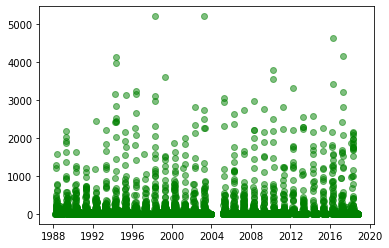

In [12]:
# Add the pollen types together for a "total pollen count".  Exclude mold spores at this time.
total_pollen = df["Tree"] + df["Grass"] + df["Ragweed"]
plt.scatter(dtg, total_pollen, c="g", alpha=0.5, marker='o')
plt.show()

In [13]:
# Add the total pollen count to the DataFrame
df["total-pol"] = total_pollen
df.columns

Index(['Tree', 'Mold', 'Grass', 'Ragweed', 'total-pol'], dtype='object')

y_values max is: 5200.0
y_values max is: 27900.0
y_values max is: 497.0
y_values max is: 208.0


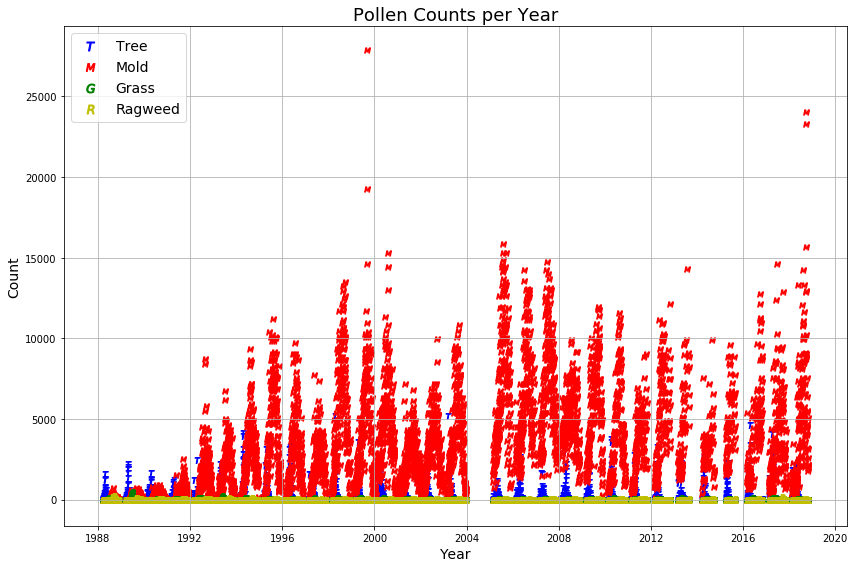

In [14]:
# Initialize the plotting parameters for the graph of each allergen

plt.figure(figsize=(12,8))
plt.title('Pollen Counts per Year', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid()

# # Make our own markers using first letter of each drug
# # enclosed in dollar signs to indicate a string

markers = ["$T$", "$M$", "$G$", "$R$"]
mkr = 0

colors = ['b','r','g','y']

# Compute the xvalues and yvalues as (timeindex, column values by column name)

#print(xval)

colnames = df.columns

# print(f"{colnames[0]}")


for a in colnames[0:4]:
    x_values = dtg
    y_values = df[a]
    print(f"y_values max is: {y_values.max()}")

    plt.scatter(x_values, y_values,
                 marker = markers[mkr], color=colors[mkr])
    mkr = mkr + 1
    
leg = plt.legend(colnames, markerscale=1.5, fontsize=14) 


# Save the Figure
plt.tight_layout()
# plt.savefig("./test.pdf")

plt.show()

In [15]:
# Need to match time intervals to the shortest length of record (Weather data starts at 1998)
df_1998 = df[df.index > "1997-12-31"]
dfdtg_1998 = pd.to_datetime(df_1998.index)

print(len(df_1998))

3565


In [16]:
df_1998.tail()

,Tree,Mold,Grass,Ragweed,total-pol
Date,,,,,
2018-10-29,0.0,1960.0,0.0,0.0,0.0
2018-10-30,0.0,2070.0,0.0,0.0,0.0
2018-10-31,0.0,2120.0,0.0,0.0,0.0
2018-11-01,0.0,2160.0,0.0,0.0,0.0
2018-11-02,0.0,1785.0,0.0,0.0,0.0


In [17]:
# Import Charlottesvile area csv file for weather at local weather stations

df2 = pd.read_csv('Wx_Cville_1998_data.csv', index_col=['DATE'], parse_dates=['DATE'])
df2.columns

Index(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'AWND', 'DAPR',
       'MDPR', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'TOBS'],
      dtype='object')

In [18]:
print(f"{df2.head()}")

                STATION                   NAME   LATITUDE  LONGITUDE  \
DATE                                                                   
2013-09-01  US1VAAB0009  SHADWELL 1.0 E, VA US  38.011627 -78.375099   
2013-09-02  US1VAAB0009  SHADWELL 1.0 E, VA US  38.011627 -78.375099   
2013-09-03  US1VAAB0009  SHADWELL 1.0 E, VA US  38.011627 -78.375099   
2013-09-04  US1VAAB0009  SHADWELL 1.0 E, VA US  38.011627 -78.375099   
2013-09-05  US1VAAB0009  SHADWELL 1.0 E, VA US  38.011627 -78.375099   

            ELEVATION  AWND  DAPR  MDPR  PRCP  TAVG  TMAX  TMIN  TOBS  
DATE                                                                   
2013-09-01      131.4   NaN   NaN   NaN   0.0   NaN   NaN   NaN   NaN  
2013-09-02      131.4   NaN   NaN   NaN   0.0   NaN   NaN   NaN   NaN  
2013-09-03      131.4   NaN   NaN   NaN   0.0   NaN   NaN   NaN   NaN  
2013-09-04      131.4   NaN   NaN   NaN   0.0   NaN   NaN   NaN   NaN  
2013-09-05      131.4   NaN   NaN   NaN   0.0   NaN   NaN   NaN

In [19]:
df2.count()

STATION      48826
NAME         48826
LATITUDE     48826
LONGITUDE    48826
ELEVATION    48826
AWND          7337
DAPR           340
MDPR           338
PRCP         48050
TAVG          2445
TMAX         29611
TMIN         29614
TOBS         18021
dtype: int64

In [20]:
dtg2 = pd.to_datetime(df2.index)

13.0


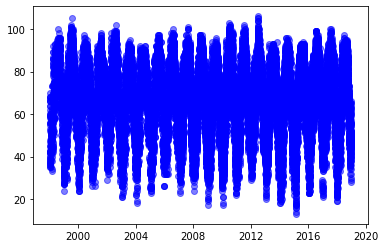

In [21]:
print(df2.TMAX.min())
plt.scatter(dtg2, df2.TMAX, c="b", alpha=0.5, marker='o')
plt.show()

In [21]:
rows = len(df2)
print(rows)

48826


### There are many incomplete records. 
Only keep rows where there is a TMAX and TMIN, so that TAVG can be computed in each cell and we drop most incomplete
records

In [22]:
df2_reduced = df2[df2.TMAX > 0]
dtg2_reduced = pd.to_datetime(df2_reduced.index)
print(len(df2_reduced))

29611


In [23]:
df2_reduced.head(20)

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,AWND,DAPR,MDPR,PRCP,TAVG,TMAX,TMIN,TOBS
DATE,,,,,,,,,,,,,
2007-03-30,USW00003759,"CHARLOTTESVILLE 2 SSE, VA US",37.9975,-78.4656,358.7,NaN,NaN,NaN,0.00,NaN,65.0,44.0,NaN
2007-03-31,USW00003759,"CHARLOTTESVILLE 2 SSE, VA US",37.9975,-78.4656,358.7,NaN,NaN,NaN,0.00,NaN,64.0,47.0,NaN
2007-04-01,USW00003759,"CHARLOTTESVILLE 2 SSE, VA US",37.9975,-78.4656,358.7,NaN,NaN,NaN,0.02,NaN,62.0,46.0,NaN
2007-04-02,USW00003759,"CHARLOTTESVILLE 2 SSE, VA US",37.9975,-78.4656,358.7,NaN,NaN,NaN,0.00,NaN,78.0,55.0,NaN
2007-04-03,USW00003759,"CHARLOTTESVILLE 2 SSE, VA US",37.9975,-78.4656,358.7,NaN,NaN,NaN,0.07,NaN,81.0,61.0,NaN
2007-04-04,USW00003759,"CHARLOTTESVILLE 2 SSE, VA US",37.9975,-78.4656,358.7,NaN,NaN,NaN,0.27,NaN,73.0,43.0,NaN
2007-04-05,USW00003759,"CHARLOTTESVILLE 2 SSE, VA US",37.9975,-78.4656,358.7,NaN,NaN,NaN,0.00,NaN,47.0,32.0,NaN
2007-04-06,USW00003759,"CHARLOTTESVILLE 2 SSE, VA US",37.9975,-78.4656,358.7,NaN,NaN,NaN,0.03,NaN,46.0,31.0,NaN
2007-04-07,USW00003759,"CHARLOTTESVILLE 2 SSE, VA US",37.9975,-78.4656,358.7,NaN,NaN,NaN,0.15,NaN,39.0,26.0,NaN


In [25]:
# Recompute TAVG from TMAX and TMIN to fill the column
tavg = (df2_reduced.TMAX + df2_reduced.TMIN) / 2

df2_reduced.loc[:, ('TAVG')] = tavg
print(df2_reduced.head())

                STATION                          NAME  LATITUDE  LONGITUDE  \
DATE                                                                         
2007-03-30  USW00003759  CHARLOTTESVILLE 2 SSE, VA US   37.9975   -78.4656   
2007-03-31  USW00003759  CHARLOTTESVILLE 2 SSE, VA US   37.9975   -78.4656   
2007-04-01  USW00003759  CHARLOTTESVILLE 2 SSE, VA US   37.9975   -78.4656   
2007-04-02  USW00003759  CHARLOTTESVILLE 2 SSE, VA US   37.9975   -78.4656   
2007-04-03  USW00003759  CHARLOTTESVILLE 2 SSE, VA US   37.9975   -78.4656   

            ELEVATION  AWND  DAPR  MDPR  PRCP  TAVG  TMAX  TMIN  TOBS  
DATE                                                                   
2007-03-30      358.7   NaN   NaN   NaN  0.00  54.5  65.0  44.0   NaN  
2007-03-31      358.7   NaN   NaN   NaN  0.00  55.5  64.0  47.0   NaN  
2007-04-01      358.7   NaN   NaN   NaN  0.02  54.0  62.0  46.0   NaN  
2007-04-02      358.7   NaN   NaN   NaN  0.00  66.5  78.0  55.0   NaN  
2007-04-03      358.7

Index(['TMAX', 'TMIN'], dtype='object')
y_values max is: 106.0
y_values max is: 84.0


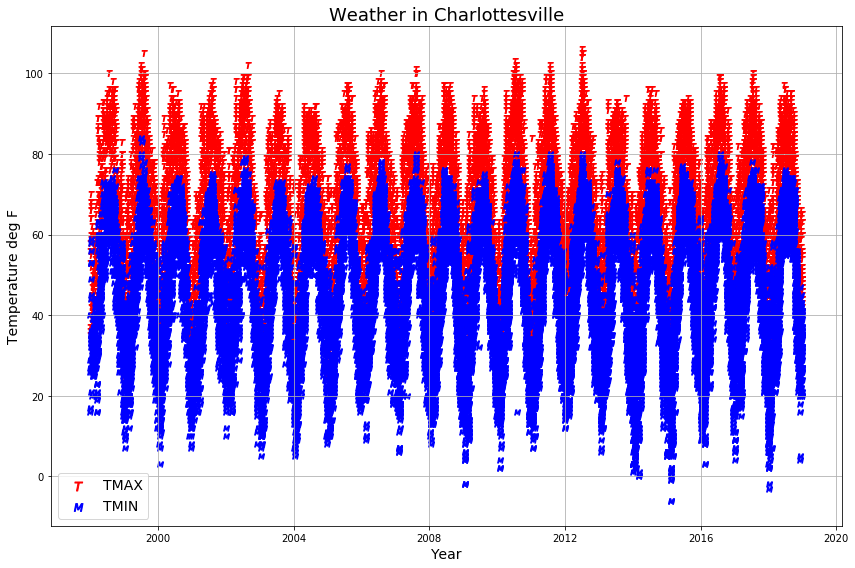

In [27]:
# Initialize the plotting parameters for the graph

plt.figure(figsize=(12,8))
plt.title('Weather in Charlottesville', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature deg F', fontsize=14)
plt.grid()

# # Make our own markers using first letter of each drug
# # enclosed in dollar signs to indicate a string

markers = ["$T$", "$M$", "$G$", "$R$"]
mkr = 0

colors = ['r','b','g','y']

# Compute the xvalues and yvalues as (timeindex, column values by column name)

#print(xval)

colnames = df2_reduced.columns[10:12]

print(f"{colnames}")

for a in colnames:
    x_values = dtg2_reduced
    y_values = df2_reduced[a]
    print(f"y_values max is: {y_values.max()}")
#     plt.scatter(x_values, y_values, c="b", alpha=0.5, marker='o')
    plt.scatter(x_values, y_values,
                 marker = markers[mkr], color=colors[mkr])
    mkr = mkr + 1

# plt.scatter(dtg2_reduced, df2_reduced.TAVG, marker='o', color='g')
leg = plt.legend(colnames, markerscale=1.5, fontsize=14) 


# Save the Figure
plt.tight_layout()
plt.savefig("./temp_CVille.pdf")

plt.show()

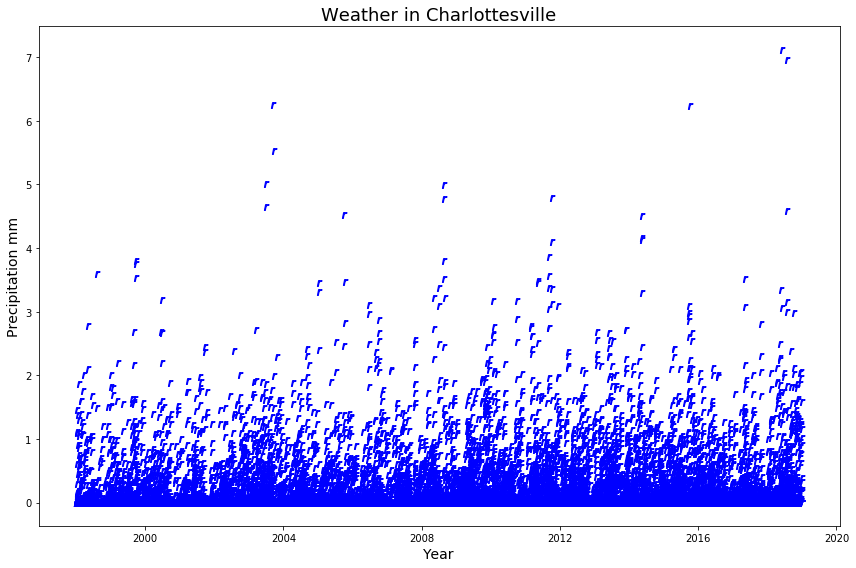

In [28]:
# Plot precip and wind speed to evaluate coverage and scale
# Initialize the plotting parameters for the graph

plt.figure(figsize=(12,8))
plt.title('Weather in Charlottesville', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Precipitation mm', fontsize=14)
plt.scatter(dtg2_reduced, df2_reduced.PRCP, marker='$r$', color='b')
plt.tight_layout()

plt.savefig('./rain_Cville.pdf')
plt.show()


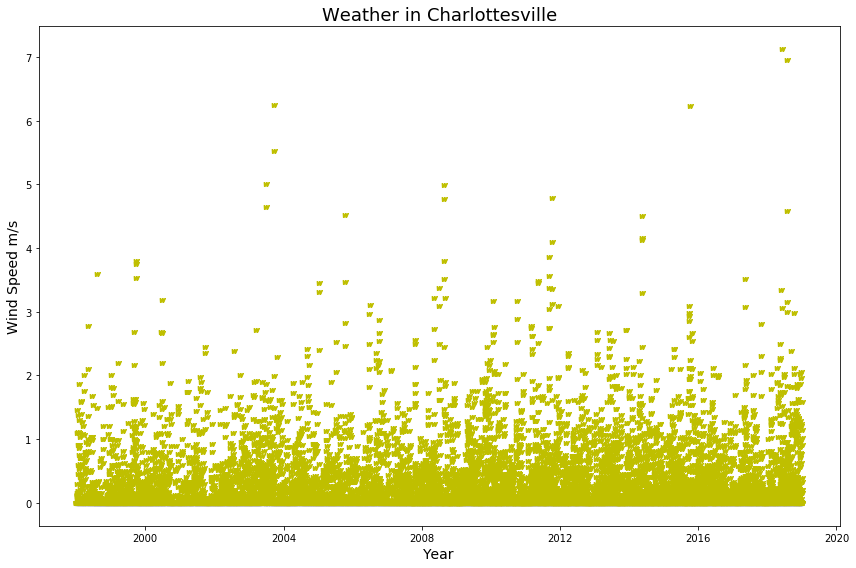

In [29]:
# Plot precip and wind speed to evaluate coverage and scale
# Initialize the plotting parameters for the graph

plt.figure(figsize=(12,8))
plt.title('Weather in Charlottesville', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Wind Speed m/s', fontsize=14)
plt.scatter(dtg2_reduced, df2_reduced.PRCP, marker='$w$', color='y')
plt.tight_layout()


plt.savefig('./wind_Cville.pdf')
plt.show()


In [30]:
# How many unique locations are there for the weather stations after reducing for complete records?
stns = df2_reduced.NAME.unique()
lats = df2_reduced.LATITUDE.unique()
lons = df2_reduced.LONGITUDE.unique()
print(f"Name and location of individual weather stations in the set: \n {stns}  {lats}  {lons} ")

d = {'station': stns, 'lat': lats, 'lon': lons}
stations_df = pd.DataFrame(data=d)
stations_df

Name and location of individual weather stations in the set: 
 ['CHARLOTTESVILLE 2 SSE, VA US' 'FREE UNION, VA US' 'MONTICELLO, VA US'
 'CHARLOTTESVILLE 2 W, VA US' 'CHARLOTTESVILLE ALBEMARLE AIRPORT, VA US']  [37.9975  38.09079 38.0111  38.0329  38.1374 ]  [-78.4656  -78.58937 -78.4494  -78.5226  -78.4552 ] 


,station,lat,lon
0,"CHARLOTTESVILLE 2 SSE, VA US",37.99750,-78.46560
1,"FREE UNION, VA US",38.09079,-78.58937
2,"MONTICELLO, VA US",38.01110,-78.44940
3,"CHARLOTTESVILLE 2 W, VA US",38.03290,-78.52260
4,"CHARLOTTESVILLE ALBEMARLE AIRPORT, VA US",38.13740,-78.45520


In [31]:
# We want to group the measurements by date and average the measurements for each day and location.
df2_groupbydate = df2_reduced.groupby("DATE").mean()
df2grp = pd.DataFrame(df2_groupbydate)
df2dtg= pd.to_datetime(df2grp.index) 
df2grp.head(20)

,LATITUDE,LONGITUDE,ELEVATION,AWND,DAPR,MDPR,PRCP,TAVG,TMAX,TMIN,TOBS
DATE,,,,,,,,,,,
1998-01-01,38.022,-78.486,247.5,NaN,NaN,NaN,0.000,26.25,36.0,16.5,28.0
1998-01-02,38.022,-78.486,247.5,NaN,NaN,NaN,0.000,35.50,44.5,26.5,39.5
1998-01-03,38.022,-78.486,247.5,NaN,NaN,NaN,0.000,45.75,57.0,34.5,48.0
1998-01-04,38.022,-78.486,247.5,NaN,NaN,NaN,0.000,51.25,63.0,39.5,48.5
1998-01-05,38.022,-78.486,247.5,NaN,NaN,NaN,0.000,53.00,66.0,40.0,54.0
1998-01-06,38.022,-78.486,247.5,NaN,NaN,NaN,0.150,59.00,65.5,52.5,58.0
1998-01-07,38.022,-78.486,247.5,NaN,NaN,NaN,0.625,62.25,69.0,55.5,64.5
1998-01-08,38.022,-78.486,247.5,NaN,NaN,NaN,0.790,61.50,67.0,56.0,60.5
1998-01-09,38.022,-78.486,247.5,NaN,NaN,NaN,0.050,53.00,62.5,43.5,47.0


In [32]:
print(len(df2grp))

7670


In [30]:
# # Need to match time intervals to the shortest length of record (SPI)
# df2grp_2010 = df2grp[df2grp.index > "2009-12-31"]
# df2dtg_2010 = pd.to_datetime(df2grp_2010.index)
# df2grp_2010.tail()
# print(len(df2grp_2010))

Index(['TMAX', 'TMIN'], dtype='object')
y_values max is: 100.4
y_values max is: 78.25


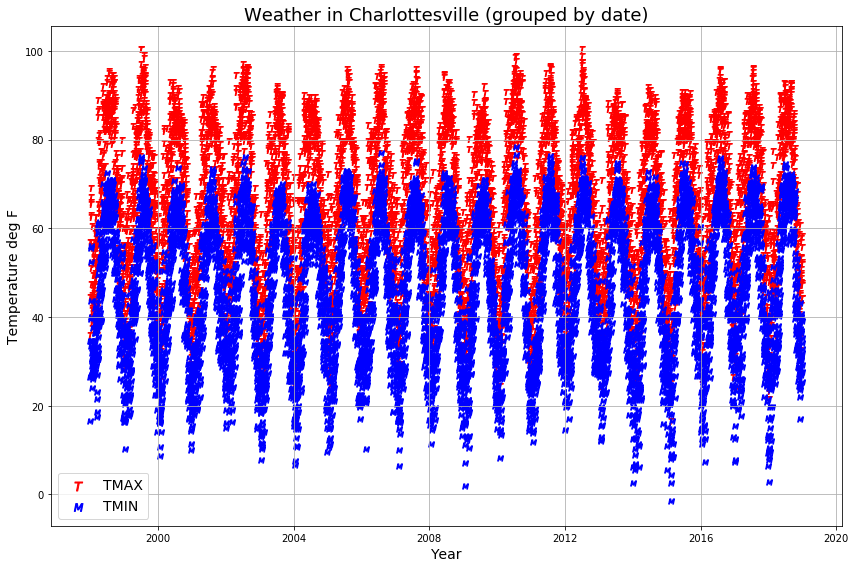

In [33]:
plt.figure(figsize=(12,8))
plt.title('Weather in Charlottesville (grouped by date)', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature deg F', fontsize=14)
plt.grid()

# # Make our own markers using first letter of each drug
# # enclosed in dollar signs to indicate a string

markers = ["$T$", "$M$", "$G$", "$R$"]
mkr = 0

colors = ['r','b','g','y']

# Compute the xvalues and yvalues as (timeindex, column values by column name)

#print(xval)

colnames = df2grp.columns[8:10]

print(f"{colnames}")

for a in colnames:
    x_values = df2dtg
    y_values = df2grp[a]
    print(f"y_values max is: {y_values.max()}")
#     plt.scatter(x_values, y_values, c="b", alpha=0.5, marker='o')
    plt.scatter(x_values, y_values,
                 marker = markers[mkr], color=colors[mkr])
    mkr = mkr + 1

# plt.scatter(dtg2_reduced, df2_reduced.TAVG, marker='o', color='g')
leg = plt.legend(colnames, markerscale=1.5, fontsize=14) 


# Save the Figure
plt.tight_layout()
# plt.savefig("./test.pdf")

plt.show()

In [34]:
# Dependencies and Setup

import gmaps

# Google developer API key
from api_keys import api_key

gmaps.configure(api_key)

In [35]:
# Plot stations on a map to see distribution and locations to show the small sample size
    
figure_layout = {
    
    'width': '800px',
    'height': '600px',
    'border': '1px solid black',
    'padding': '1px',
    'margin': '0 auto 0 auto'
}

fig = gmaps.figure(layout=figure_layout)

locations = stations_df[["lat", "lon"]]

stations_layer = gmaps.symbol_layer(
    locations, fill_color="blue", stroke_color="blue", scale=5 )

fig.add_layer(stations_layer)
fig

Figure(layout=FigureLayout(border='1px solid black', height='600px', margin='0 auto 0 auto', padding='1px', wi…

###  Now need to merge the "features" with the "target" on common dates
Use the shortest dataframe as the basis, since all cells must be filled in order to use sklearn ML routines

In [38]:
# First merge the pollen and weather files on Date
first_merge = pd.merge(df_1998, df2grp, left_index=True, right_index=True, how='inner')
first_merge.head()

,Tree,Mold,Grass,Ragweed,total-pol,LATITUDE,LONGITUDE,ELEVATION,AWND,DAPR,MDPR,PRCP,TAVG,TMAX,TMIN,TOBS
1998-02-20,46.0,180.0,0.0,0.0,46.0,38.022,-78.486,247.5,NaN,NaN,NaN,0.040,49.00,60.0,38.0,41.0
1998-02-24,5.0,450.0,0.0,0.0,5.0,38.022,-78.486,247.5,NaN,NaN,NaN,0.295,42.50,48.5,36.5,44.0
1998-02-25,18.0,210.0,0.0,0.0,18.0,38.022,-78.486,247.5,NaN,NaN,NaN,0.000,48.75,57.0,40.5,45.5
1998-02-26,124.0,960.0,0.0,0.0,124.0,38.022,-78.486,247.5,NaN,NaN,NaN,0.000,50.75,62.5,39.0,44.5
1998-02-27,504.0,1260.0,0.0,0.0,504.0,38.022,-78.486,247.5,NaN,NaN,NaN,0.000,51.50,62.5,40.5,43.5


In [39]:
print(len(first_merge))

3565


### Ta-Da!!  The final merged file that can be used in the Ml NN routines.

In [40]:
pollen_wx_Cville_df = first_merge


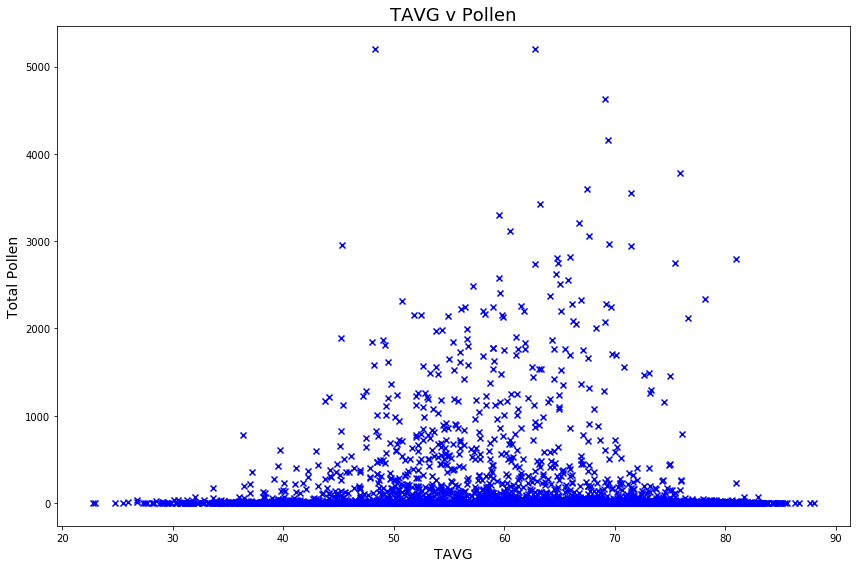

In [41]:


plt.figure(figsize=(12,8))
plt.title('TAVG v Pollen', fontsize=18)
plt.xlabel('TAVG', fontsize=14)
plt.ylabel('Total Pollen', fontsize=14)

# spi_neg = df3[df3 <0]
# dtgn = pd.to_datetime(df3_neg.index)
# df3_pos = df3[df3 >= 0]
# dtgp = pd.to_datetime(df3_pos.index)
xval = pollen_wx_Cville_df.TAVG
yval = pollen_wx_Cville_df["total-pol"]

plt.scatter(xval,yval, marker='x', c='b')
plt.tight_layout()

#plt.savefig('./wind.pdf')
plt.show()


In [42]:
#  Write the combined file to another CSV to use in the ML notebook.

pollen_wx_Cville_df.to_csv("./pollen_wx_Cville.csv")
